In [1]:
import numpy as np
from scipy import signal
from matplotlib.figure import Figure
from matplotlib.axes import Axes
import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams.update(
    {
        "font.size": 7,
        "figure.dpi": 200
    }
)

In [11]:
from typing import NamedTuple

RNG = np.random.default_rng(2000)

class SinusoidSignal(NamedTuple):
    t: np.ndarray
    x: np.ndarray

def generate_test_signal(omega_1: float, omega_2: float, f_s: float, with_noise: bool = False, t_final: float = 10) -> SinusoidSignal:
    dt = 1/f_s
    t: np.ndarray = np.linspace(0, t_final, round(t_final/dt))
    return SinusoidSignal(
        t,
        x=np.sin(2 * np.pi * omega_1 * t) + np.sin(2 * np.pi * omega_2 * t) +  with_noise * RNG.normal(0, scale=1, size=t.shape)
    )

generate_test_signal(omega_1=0.2, omega_2=0.5, f_s=2, t_final=10)

SinusoidSignal(t=array([ 0.        ,  0.52631579,  1.05263158,  1.57894737,  2.10526316,
        2.63157895,  3.15789474,  3.68421053,  4.21052632,  4.73684211,
        5.26315789,  5.78947368,  6.31578947,  6.84210526,  7.36842105,
        7.89473684,  8.42105263,  8.94736842,  9.47368421, 10.        ]), x=array([ 0.00000000e+00,  1.61079721e+00,  8.04805676e-01, -5.36269393e-02,
        8.00646862e-01,  7.51178736e-01, -1.21167130e+00, -1.83375097e+00,
       -2.22953766e-01,  4.11024441e-01, -4.11024441e-01,  2.22953766e-01,
        1.83375097e+00,  1.21167130e+00, -7.51178736e-01, -8.00646862e-01,
        5.36269393e-02, -8.04805676e-01, -1.61079721e+00, -1.71450552e-15]))

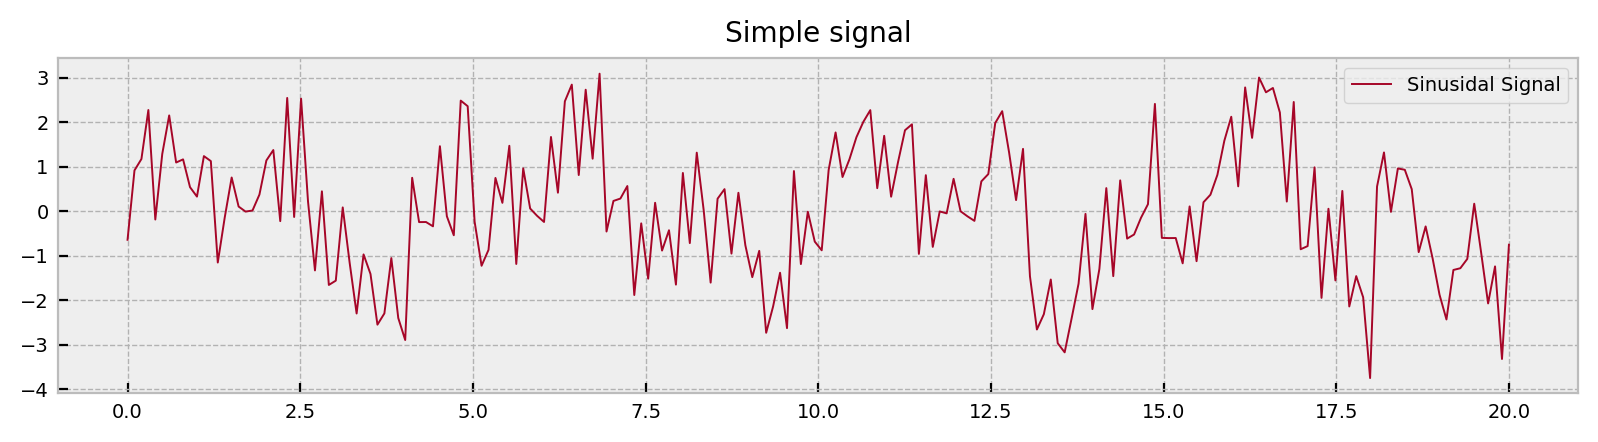

In [14]:
def plot_sinusidal_signal(sinusidal_signal: SinusoidSignal) -> None:
    fig: Figure = plt.figure(figsize=(16//2, 9//2))
    ax: Axes = fig.add_subplot(211)
    ax.plot(sinusidal_signal.t, sinusidal_signal.x, color="C1",
            label="Sinusidal Signal", linewidth=0.7)
    ax.legend()
    plt.title("Simple signal")
    plt.tight_layout()
    plt.show()
    
plot_sinusidal_signal(
    sinusidal_signal=generate_test_signal(omega_1=0.2, omega_2=0.5, f_s=10, t_final=20, with_noise=True)
)

## First Lets design a filter

The filter will be a simple fir filter with a cutoff frequency at 0.5 $\pi$ with n taps 

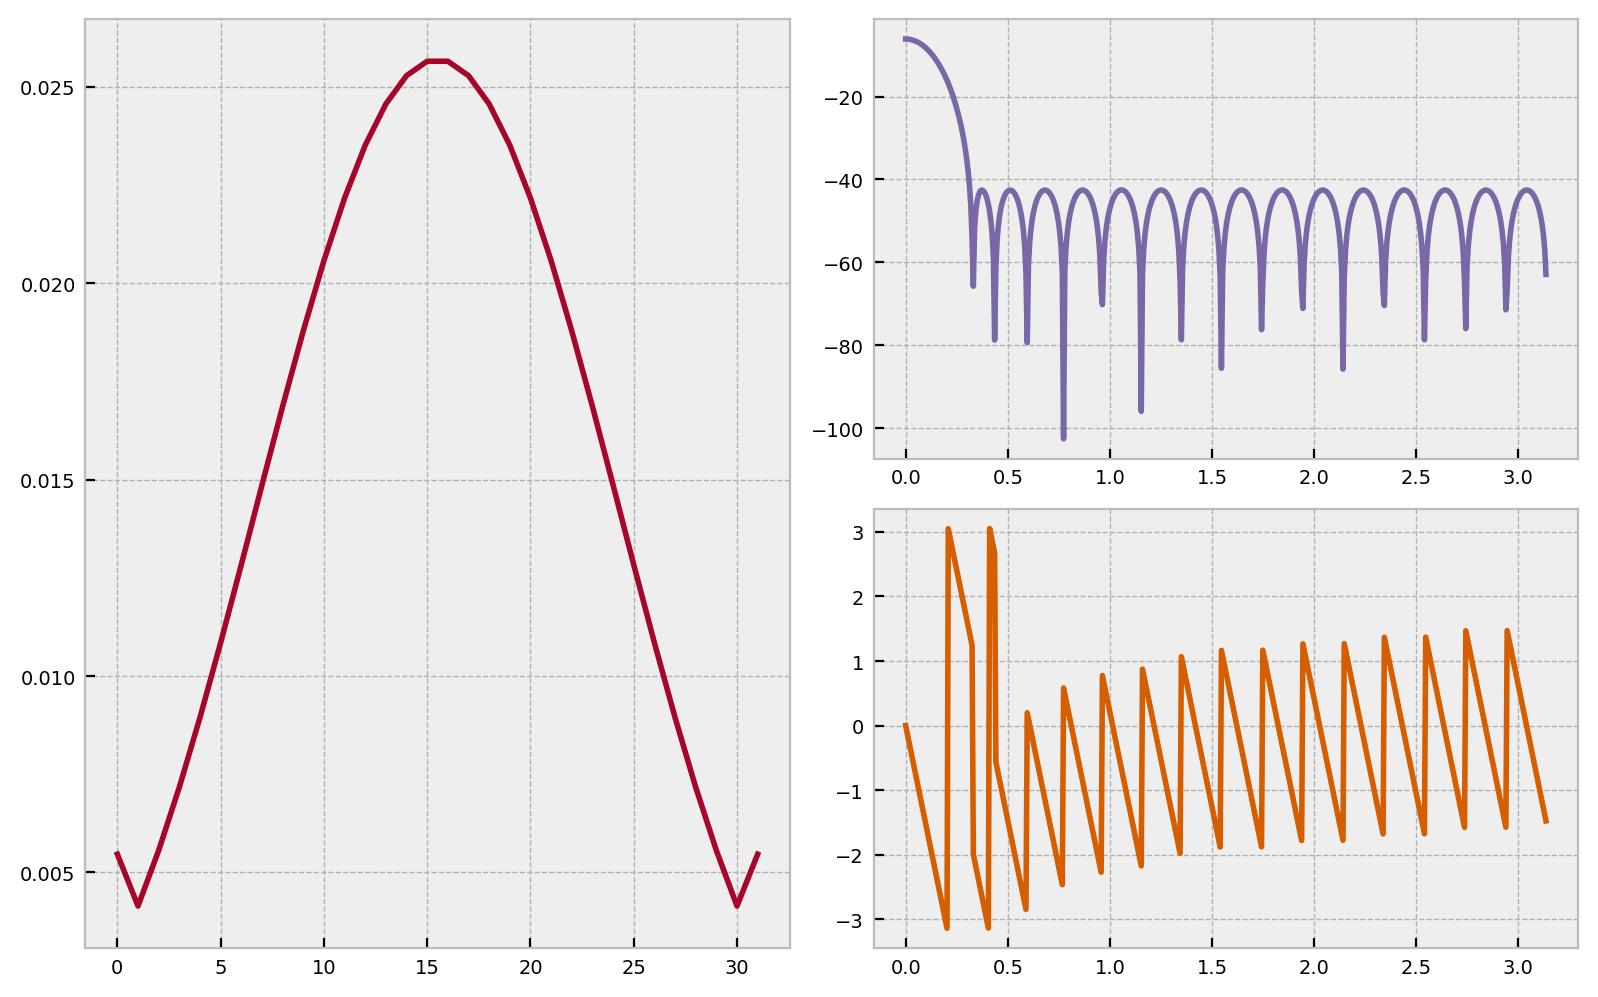

In [27]:
import dataclasses
import abc

class IFilter(abc.ABC):
    @abc.abstractmethod
    def generate_filter(self) -> np.ndarray:
        raise NotImplementedError
    
    def plot_filter(self) -> None:
        coefficients = self.generate_filter()
        w, h_response = signal.freqz(coefficients)
        fig: Figure = plt.figure(figsize=(16//2, 9/1.8))
        axes: dict[str, Axes] = fig.subplot_mosaic([
            ["coefficients", "amplitude_response"],
            ["coefficients", "phase_response"],
        ])
        axes["coefficients"].plot(self.generate_filter(), color="C1", label="Filter Coefficients")
        axes["amplitude_response"].plot(w, 20 * np.log10(np.abs(h_response)), color="C2", label="|H(s)|")
        axes["phase_response"].plot(w, np.angle(h_response), color="C4", label="< H(s)")
        plt.tight_layout()
        plt.show()
        
    

@dataclasses.dataclass
class UnWarpedFilter(IFilter):
    taps: int
    cutoff_points: list[float]
    gains: list[float]
    weights: list[float]
    
    def generate_filter(self) -> np.ndarray:
        return signal.remez(self.taps, bands=self.cutoff_points, desired=self.gains, weight=self.weights)
    
    
    
unwarped_filter = UnWarpedFilter(
    taps=2**5,
    cutoff_points=[0, 0.025, 0.025+0.025, 0.5],
    gains=[1,0],
    weights=[1, 100]
)

unwarped_filter.plot_filter()
        

In [28]:
@dataclasses.dataclass
class WarpedLowPassFileter(IFilter):
    cuttoff_frequency: float
    sampling_frequncy: float
    
    def __warping_phase(self, a: float):
        w = self.cuttoff_frequency
        theta = np.angle(a)
        r = np.abs(a);
        wy = - w - 2 * np.arctan((r*np.sin(w - theta))/(1 - r*np.cos(w - theta)))
        return wy
    
    def generate_filter(self) -> np.ndarray:
        a = 1.0674*(2/np.pi*np.arctan(0.06583*self.sampling_frequncy))**0.5 - 0.1916
        f_cut_off_warperd = -self.__warping_phase(a)
        f_cut_off_normalized =f_cut_off_warperd/(2*np.pi)
        return signal.remez(4, [0, f_cut_off_normalized, f_cut_off_normalized+0.1, 0.5],[1, 0], weight=[1, 100])
    
warped_filter = WarpedLowPassFileter(
    cuttoff_frequency=0.5, # Normalized Frequency
    sampling_frequncy=2
)

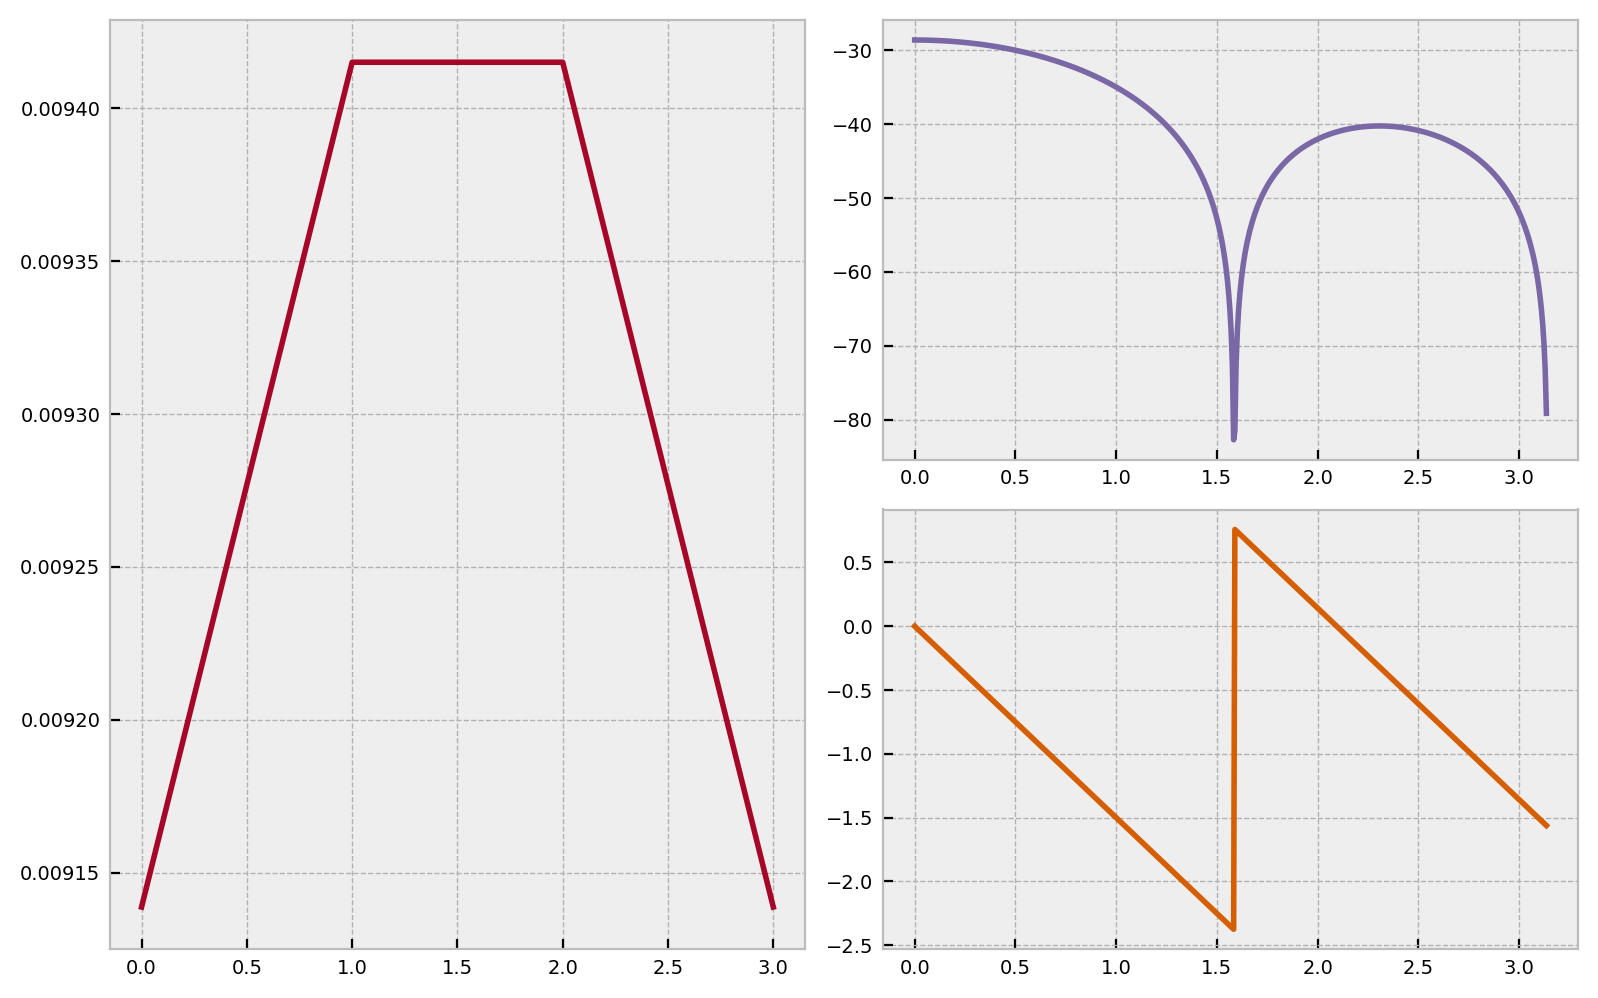

In [29]:
warped_filter.plot_filter()